# Analysis of Survivor Winners

**Karina Chen**

Question: To what extent can we predict the winner of a season of Survivor based on their demographics (race, gender, age, mbti, etc)? Can we predict which contestant (out of the final two/three) will win based on voting patterns (how many times they were voted against, how many times they voted for the person that actually went home) and possession of advantages (immunity idol, extra vote, winning reward, etc)?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [84]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression

**Data**

In [3]:
advantage_details = pd.read_csv('data/advantage_details.csv')
advantage_movement = pd.read_csv('data/advantage_movement.csv')
boot_mapping = pd.read_csv('data/boot_mapping.csv')
castaway_details = pd.read_csv('data/castaway_details.csv')
castaways = pd.read_csv('data/castaways.csv')
challenge_description = pd.read_csv('data/challenge_description.csv')
challenge_results = pd.read_csv('data/challenge_results.csv')
confessionals = pd.read_csv('data/confessionals.csv')
hidden_idols = pd.read_csv('data/hidden_idols.csv')
jury_votes = pd.read_csv('data/jury_votes.csv')
season_summary = pd.read_csv('data/season_summary.csv')
tribe_colours = pd.read_csv('data/tribe_colours.csv')
tribe_mapping = pd.read_csv('data/tribe_mapping.csv')
vote_history = pd.read_csv('data/vote_history.csv')

The advantage_details dataset contains the details and characteristics of each idol and advantage.

In [4]:
advantage_details.head()

,version,version_season,season_name,season,advantage_id,advantage_type,clue_details,location_found,conditions
0,US,US11,Survivor: Guatemala,11,USHI1101,Hidden immunity idol,Found without clue,Found around camp,Play before votes are cast
1,US,US12,Survivor: Panama,12,USSI1201,Super idol,Found on Exile,Advantage from Exile,Play after votes are read; Valid until F4
2,US,US13,Survivor: Cook Islands,13,USSI1301,Super idol,Found on Exile,Advantage from Exile,Play after votes are read; Valid until F4
3,US,US14,Survivor: Fiji,14,USHI1401,Hidden immunity idol,Found on Exile,Found around camp,NaN
4,US,US14,Survivor: Fiji,14,USHI1402,Hidden immunity idol,Someone shared the clue,Found around camp,NaN


The advantage_movement dataset contains the movement details of each advantage or hidden immunity idol. Each row is
considered an event e.g. the idol was found, played, etc. If the advantage changed hands it records who received it.

In [5]:
advantage_movement.head()

,version,version_season,season_name,season,castaway,castaway_id,advantage_id,sequence_id,day,episode,event,played_for,played_for_id,success,votes_nullified
0,US,US11,Survivor: Guatemala,11,Gary,US0161,USSI1101,1,24,9,Found,NaN,NaN,NaN,NaN
1,US,US11,Survivor: Guatemala,11,Gary,US0161,USSI1101,2,24,9,Played,Gary,US0161,Yes,0.0
2,US,US12,Survivor: Panama,12,Terry,US0180,USSI1201,1,9,4,Found,NaN,NaN,NaN,NaN
3,US,US12,Survivor: Panama,12,Terry,US0180,USSI1201,2,37,15,Expired,NaN,NaN,NaN,NaN
4,US,US13,Survivor: Cook Islands,13,Yul,US0202,USSI1301,1,5,2,Found,NaN,NaN,NaN,NaN


The boot_mapping dataset is a mapping table for easily filtering to the set of castaways that are still in the game after a specified number of boots.

In [6]:
boot_mapping.head()

,version,version_season,season_name,season,episode,order,castaway,castaway_id,tribe,tribe_status,in_the_game
0,US,US01,Survivor: Borneo,1,1,0,Sonja,US0001,Tagi,Original,True
1,US,US01,Survivor: Borneo,1,1,0,B.B.,US0002,Pagong,Original,True
2,US,US01,Survivor: Borneo,1,1,0,Stacey,US0003,Tagi,Original,True
3,US,US01,Survivor: Borneo,1,1,0,Ramona,US0004,Pagong,Original,True
4,US,US01,Survivor: Borneo,1,1,0,Dirk,US0005,Tagi,Original,True


The castaway_details dataset contains details on the castaways for each season, including gender, race, and occupation.

In [7]:
castaway_details.head()

,castaway_id,full_name,short_name,date_of_birth,date_of_death,gender,race,ethnicity,poc,occupation,personality_type
0,US0001,Sonja Christopher,Sonja,1937-01-28,NaN,Female,NaN,NaN,White,Musician,ENFP
1,US0002,B.B. Andersen,B.B.,1936-01-18,2013-10-29,Male,NaN,NaN,White,Real Estate Developer,ESTJ
2,US0003,Stacey Stillman,Stacey,1972-08-11,NaN,Female,NaN,NaN,White,Attorney,ENTJ
3,US0004,Ramona Gray,Ramona,1971-01-20,NaN,Female,Black,NaN,POC,Biochemist/Chemist,ISTJ
4,US0005,Dirk Been,Dirk,1976-06-15,NaN,Male,NaN,NaN,White,Dairy Farmer,ISFP


The castaways dataset contains details on the results for every castaway and season.

In [8]:
castaways.head()

,version,version_season,season_name,season,full_name,castaway_id,castaway,age,city,state,personality_type,episode,day,order,result,jury_status,original_tribe
0,US,US01,Survivor: Borneo,1,Richard Hatch,US0016,Richard,39,Newport,Rhode Island,ENTP,14,39,16,Sole Survivor,NaN,Tagi
1,US,US01,Survivor: Borneo,1,Kelly Wiglesworth,US0015,Kelly,22,Kernville,California,ISFP,14,39,15,Runner-up,NaN,Tagi
2,US,US01,Survivor: Borneo,1,Rudy Boesch,US0014,Rudy,72,Virginia Beach,Virginia,ISTJ,13,38,14,14th voted out,7th jury member,Tagi
3,US,US01,Survivor: Borneo,1,Susan Hawk,US0013,Sue,38,Palmyra,Wisconsin,ESTP,13,37,13,13th voted out,6th jury member,Tagi
4,US,US01,Survivor: Borneo,1,Sean Kenniff,US0012,Sean,30,Carle Place,New York,INTP,12,36,12,12th voted out,5th jury member,Tagi


The challenge_description dataset details the challenges played and the elements they include over all seasons of Survivor.

In [9]:
challenge_description.head()

,challenge_id,challenge_name,puzzle,race,precision,endurance,strength,turn_based,balance,food,knowledge,memory,fire,water
0,CC0053,Barrel of Monkeys,False,True,True,False,False,False,False,False,False,False,False,True
1,CC0079,Blue Lagoon Bustle,True,True,True,False,False,False,False,False,False,False,False,True
2,CC0114,By the Numbers,False,True,False,False,False,False,True,False,False,False,False,True
3,CC0138,Choose Your Weapon,False,True,True,False,False,True,False,False,False,False,False,False
4,CC0232,Flashback,False,False,False,True,False,False,False,False,True,True,False,False


The challenge_results dataset details the challenges played including reward and immunity challenges.

In [10]:
challenge_results.head()

,version,version_season,season_name,season,episode,day,order,episode_title,challenge_name,challenge_type,outcome_type,challenge_id,winners
0,US,US01,Survivor: Borneo,1,1,3,0,The Marooning,Quest for Fire,Reward and Immunity,Tribal,CH0001,"list(winner_id = c(""US0002"", ""US0004"", ""US0006..."
1,US,US01,Survivor: Borneo,1,2,6,1,The Generation Gap,Buggin' Out,Immunity,Tribal,CH0004,"list(winner_id = c(""US0003"", ""US0005"", ""US0012..."
2,US,US01,Survivor: Borneo,1,2,6,1,The Generation Gap,Shoulder the Load,Reward,Tribal,CH0357,"list(winner_id = c(""US0002"", ""US0004"", ""US0006..."
3,US,US01,Survivor: Borneo,1,3,9,2,Quest for Food,Rescue Mission,Immunity,Tribal,CH0021,"list(winner_id = c(""US0004"", ""US0006"", ""US0007..."
4,US,US01,Survivor: Borneo,1,3,9,2,Quest for Food,Treasure Chest,Reward,Tribal,CH0020,"list(winner_id = c(""US0003"", ""US0005"", ""US0012..."


The confessionals dataset contains the count of confessionals per castaway per episode. A confessional is when the castaway is speaking directly to the camera about their game.

In [11]:
confessionals.head()

,version,version_season,season_name,season,episode,castaway,castaway_id,confessional_count
0,US,US01,Survivor: Borneo,1,1,B.B.,US0002,3
1,US,US01,Survivor: Borneo,1,1,Colleen,US0011,0
2,US,US01,Survivor: Borneo,1,1,Dirk,US0005,1
3,US,US01,Survivor: Borneo,1,1,Gervase,US0010,0
4,US,US01,Survivor: Borneo,1,1,Greg,US0008,0


The hidden_idols dataset contains details on the hidden immunity idols.

In [12]:
hidden_idols.head()

,season_name,season,castaway_id,castaway,idol_number,idols_held,votes_nullified,day_found,day_played,legacy_advantage
0,Survivor: Guatemala,11,US0161,Gary,1,1,0.0,24.0,NaN,False
1,Survivor: Panama,12,US0180,Terry,1,1,0.0,NaN,NaN,False
2,Survivor: Cook Islands,13,US0202,Yul,1,1,0.0,NaN,NaN,False
3,Survivor: Fiji,14,US0218,Yau-Man,1,1,4.0,17.0,36.0,False
4,Survivor: Fiji,14,US0214,Mookie,1,1,0.0,20.0,NaN,False


The jury_votes dataset contains details on the final jury votes to determine the winner for each season.

In [13]:
jury_votes.head()

,version,version_season,season_name,season,castaway,finalist,vote,castaway_id,finalist_id
0,US,US01,Survivor: Borneo,1,Colleen,Kelly,1,US0011,US0015
1,US,US01,Survivor: Borneo,1,Gervase,Kelly,1,US0010,US0015
2,US,US01,Survivor: Borneo,1,Greg,Kelly,0,US0008,US0015
3,US,US01,Survivor: Borneo,1,Jenna,Kelly,1,US0009,US0015
4,US,US01,Survivor: Borneo,1,Rudy,Kelly,0,US0014,US0015


The season_summary dataset contains a summary of all the seasons of Survivor.

In [14]:
season_summary.head()

,version,version_season,season_name,season,location,country,tribe_setup,full_name,winner_id,winner,...,timeslot,premiered,ended,filming_started,filming_ended,viewers_premier,viewers_finale,viewers_reunion,viewers_mean,rank
0,US,US01,Survivor: Borneo,1,"Pulau Tiga, Sabah, Malaysia",Malaysia,Two tribes of eight new players,Richard Hatch,US0016,Richard,...,Wednesday 8:00 pm,2000-05-31,2000-08-23,2000-03-13,2000-04-20,15.51,51.69,36.70,28.30,2.0
1,US,US02,Survivor: The Australian Outback,2,"Herbert River at Goshen Station, Queensland, A...",Australia,Two tribes of eight new players,Tina Wesson,US0032,Tina,...,Thursday 8:00 pm,2001-01-28,2001-05-03,2000-10-23,2000-12-03,45.37,36.35,28.01,29.80,1.0
2,US,US03,Survivor: Africa,3,"Shaba National Reserve, Kenya",Kenya,Two tribes of eight new players,Ethan Zohn,US0048,Ethan,...,Thursday 8:00 pm,2001-10-11,2002-01-10,2001-07-11,2001-08-18,23.84,27.26,19.05,20.69,8.0
3,US,US04,Survivor: Marquesas,4,"Nuku Hiva, Marquesas Islands, French Polynesia",Polynesia,Two tribes of eight new players,Vecepia Towery,US0064,Vecepia,...,Thursday 8:00 pm,2002-02-28,2002-05-19,2001-11-12,2001-12-20,23.19,25.87,19.05,20.77,6.0
4,US,US05,Survivor: Thailand,5,"Ko Tarutao, Satun Province, Thailand",Thailand,Two tribes of eight new players; picked by the...,Brian Heidik,US0080,Brian,...,Thursday 8:00 pm,2002-09-19,2002-12-19,2002-06-10,2002-07-18,23.05,24.08,20.43,21.21,4.0


The tribe_colours dataset contains the tribe colours for each season.

In [15]:
tribe_colours.head()

,version,version_season,season_name,season,tribe,tribe_colour,tribe_status
0,US,US01,Survivor: Borneo,1,Pagong,#FFFF05,Original
1,US,US01,Survivor: Borneo,1,Rattana,#7CFC00,Merged
2,US,US01,Survivor: Borneo,1,Tagi,#FF9900,Original
3,US,US02,Survivor: The Australian Outback,2,Barramundi,#FF6600,Merged
4,US,US02,Survivor: The Australian Outback,2,Kucha,#32CCFF,Original


The tribe_mapping dataset is a mapping for castaways to tribes for each day (day being the day of the tribal council) This is useful for observing who is on what tribe throughout the game.

In [16]:
tribe_mapping.head()

,version,version_season,season_name,season,episode,day,castaway_id,castaway,tribe,tribe_status
0,US,US01,Survivor: Borneo,1,1,3,US0002,B.B.,Pagong,Original
1,US,US01,Survivor: Borneo,1,1,3,US0004,Ramona,Pagong,Original
2,US,US01,Survivor: Borneo,1,1,3,US0006,Joel,Pagong,Original
3,US,US01,Survivor: Borneo,1,1,3,US0007,Gretchen,Pagong,Original
4,US,US01,Survivor: Borneo,1,1,3,US0008,Greg,Pagong,Original


The vote_history dataset contains details on the vote history for each season.

In [17]:
vote_history.head()

,version,version_season,season_name,season,episode,day,tribe_status,tribe,castaway,immunity,...,vote_event,split_vote,nullified,tie,voted_out,order,vote_order,castaway_id,vote_id,voted_out_id
0,US,US01,Survivor: Borneo,1,1,3,Original,Tagi,Sonja,NaN,...,NaN,NaN,False,False,Sonja,1,1,US0001,US0014,US0001
1,US,US01,Survivor: Borneo,1,1,3,Original,Tagi,Stacey,NaN,...,NaN,NaN,False,False,Sonja,1,1,US0003,US0014,US0001
2,US,US01,Survivor: Borneo,1,1,3,Original,Tagi,Dirk,NaN,...,NaN,NaN,False,False,Sonja,1,1,US0005,US0001,US0001
3,US,US01,Survivor: Borneo,1,1,3,Original,Tagi,Sean,NaN,...,NaN,NaN,False,False,Sonja,1,1,US0012,US0001,US0001
4,US,US01,Survivor: Borneo,1,1,3,Original,Tagi,Sue,NaN,...,NaN,NaN,False,False,Sonja,1,1,US0013,US0001,US0001


__________

In [18]:
advantage_movement['event'].unique()

array(['Found', 'Played', 'Expired', 'Received',
       'Voted out with advantage', 'Activated', 'Destroyed', 'Absorbed'],
      dtype=object)

____________________________

**Exploratory Data Analysis**

In [19]:
castaway_details.groupby('gender')['castaway_id'].count()

gender
Female        312
Male          313
Non-binary      1
Name: castaway_id, dtype: int64

Gender is evenly distributed between male and female.

In [20]:
castaway_details.groupby('poc')['castaway_id'].count()

poc
POC      186
White    440
Name: castaway_id, dtype: int64

There have been a lot more white players than players of color.

In [21]:
castaways.groupby('personality_type')['castaway_id'].count().sort_values(ascending=False) # two NaN values

personality_type
ENFP    77
ESFP    70
ISFP    67
ESTP    64
ESTJ    56
INFP    55
ISTJ    53
ENTP    51
INTP    42
ENFJ    41
ESFJ    40
ISFJ    37
ENTJ    34
ISTP    34
INFJ    29
INTJ    27
Name: castaway_id, dtype: int64

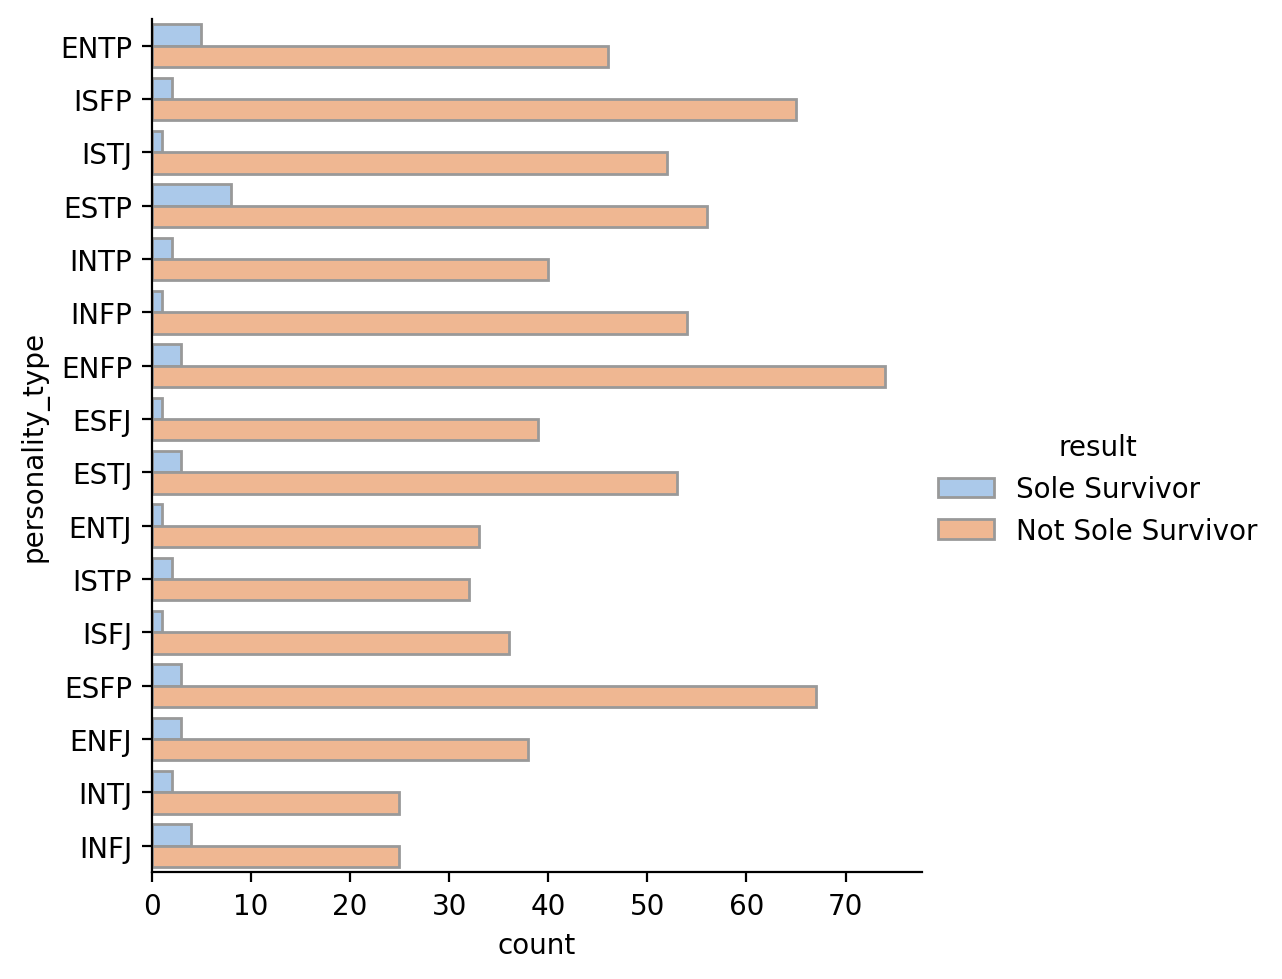

In [22]:
castaways_copy = castaways.copy()
castaways_copy['result'] = castaways_copy['result'].apply(lambda x: x if x == 'Sole Survivor' else 'Not Sole Survivor')

sns.catplot(y="personality_type", hue="result", kind="count",
            palette="pastel", edgecolor=".6",
            data=castaways_copy)

In [23]:
win_by_personality = pd.pivot_table(castaways_copy, columns='result', index='personality_type', values='age', aggfunc='count')
win_by_personality

result,Not Sole Survivor,Sole Survivor
personality_type,,
ENFJ,38,3
ENFP,74,3
ENTJ,33,1
ENTP,46,5
ESFJ,39,1
ESFP,67,3
ESTJ,53,3
ESTP,56,8
INFJ,25,4


In [24]:
(win_by_personality['Sole Survivor'] / (win_by_personality['Sole Survivor'] + win_by_personality['Not Sole Survivor'])).sort_values(ascending=False)

personality_type
INFJ    0.137931
ESTP    0.125000
ENTP    0.098039
INTJ    0.074074
ENFJ    0.073171
ISTP    0.058824
ESTJ    0.053571
INTP    0.047619
ESFP    0.042857
ENFP    0.038961
ISFP    0.029851
ENTJ    0.029412
ISFJ    0.027027
ESFJ    0.025000
ISTJ    0.018868
INFP    0.018182
dtype: float64

The personality types that have won most often are INFJ, ESTP, and ENTP.

__________________

Predict winner only based on castaway characteristics and traits (gender, age, poc, personality type, state).

In [25]:
all_castaways = castaway_details.merge(castaways[['season', 'castaway_id', 'age', 'state', 'result']], on='castaway_id', how='left')
all_castaways = all_castaways[['full_name', 'gender', 'poc', 'personality_type', 'age', 'state', 'season', 'result']]
all_castaways

,full_name,gender,poc,personality_type,age,state,season,result
0,Sonja Christopher,Female,White,ENFP,63,California,1,1st voted out
1,B.B. Andersen,Male,White,ESTJ,64,Kansas,1,2nd voted out
2,Stacey Stillman,Female,White,ENTJ,27,California,1,3rd voted out
3,Ramona Gray,Female,POC,ISTJ,29,New Jersey,1,4th voted out
4,Dirk Been,Male,White,ISFP,23,Wisconsin,1,5th voted out
...,...,...,...,...,...,...,...,...
775,Rocksroy Bailey,Male,POC,ESTJ,43,Nevada,42,8th voted out
776,Romeo Escobar,Male,POC,ISFP,37,California,42,2nd runner-up
777,Swati Goel,Female,POC,ISTJ,19,California,42,4th voted out
778,Tori Meehan,Female,White,ENFJ,24,Arizona,42,9th voted out


In [26]:
# 1 is sole survivor, 0 is not
all_castaways['result'] = all_castaways['result'].apply(lambda x: 1 if x == 'Sole Survivor' else 0)
# # 0 is female, 1 is male, 2 is other
# all_castaways['gender'] = all_castaways['gender'].apply(lambda x: 0 if x == 'Female' else 1 if x == 'Male' else 2)
# # 0 is white, 1 is poc
# all_castaways['poc'] = all_castaways['poc'].apply(lambda x: 0 if x == 'White' else 1)
all_castaways

,full_name,gender,poc,personality_type,age,state,season,result
0,Sonja Christopher,Female,White,ENFP,63,California,1,0
1,B.B. Andersen,Male,White,ESTJ,64,Kansas,1,0
2,Stacey Stillman,Female,White,ENTJ,27,California,1,0
3,Ramona Gray,Female,POC,ISTJ,29,New Jersey,1,0
4,Dirk Been,Male,White,ISFP,23,Wisconsin,1,0
...,...,...,...,...,...,...,...,...
775,Rocksroy Bailey,Male,POC,ESTJ,43,Nevada,42,0
776,Romeo Escobar,Male,POC,ISFP,37,California,42,0
777,Swati Goel,Female,POC,ISTJ,19,California,42,0
778,Tori Meehan,Female,White,ENFJ,24,Arizona,42,0


In [27]:
all_castaways.isna().sum()

full_name           0
gender              0
poc                 0
personality_type    3
age                 0
state               0
season              0
result              0
dtype: int64

In [28]:
print("Number of NaN personality types: " + str(all_castaways[all_castaways['personality_type'].isna()].shape[0]))
print("After a search, we can manually impute the values: Laura is ENFP and Ron is ENTJ")
all_castaways[all_castaways['full_name'] == 'Laura Boneham'] = all_castaways[all_castaways['full_name'] == 'Laura Boneham'].fillna("ENFP")
all_castaways[all_castaways['full_name'] == 'Ron Clark'] = all_castaways[all_castaways['full_name'] == 'Ron Clark'].fillna("ENTJ")
all_castaways.isna().sum()

Number of NaN personality types: 3
After a search, we can manually impute the values: Laura is ENFP and Ron is ENTJ


full_name           0
gender              0
poc                 0
personality_type    0
age                 0
state               0
season              0
result              0
dtype: int64

In [29]:
features = all_castaways[['gender', 'poc', 'personality_type', 'age', 'state']]
label = all_castaways['result']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

In [30]:
nom_features = ['personality_type', 'gender', 'poc', 'state']
quan_features = ['age']

In [31]:
preproc = ColumnTransformer([
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), nom_features),
    ('scale', StandardScaler(), quan_features)
], remainder='passthrough')

In [32]:
mod = SVC()
pl = Pipeline([
    ('preprocessing', preproc),
    ('model', mod)
])

In [40]:
errs = cross_val_score(pl, X_train, y_train, cv=10, scoring='accuracy')
errs

array([0.93650794, 0.93650794, 0.93650794, 0.93650794, 0.9516129 ,
       0.9516129 , 0.9516129 , 0.93548387, 0.93548387, 0.93548387])

In [41]:
avg_acc = np.mean(errs)
avg_acc

0.9407322068612392

A model's predictions are "good" when it has a greater accuracy than the accuracy of just predicting all 0s or all 1s.

In [42]:
all_ones = np.array([1] * label.shape[0])
all_zeros = np.array([0] * label.shape[0])
acc_threshold = np.maximum(accuracy_score(label, all_ones), accuracy_score(label, all_zeros))
acc_threshold

0.9461538461538461

In [43]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['personality_type', 'gender',
                                                   'poc', 'state']),
                                                 ('scale', StandardScaler(),
                                                  ['age'])])),
                ('model', SVC())])

In [44]:
pred_test = pl.predict(X_test)
score = accuracy_score(y_test, pred_test)
score

0.967948717948718

In [45]:
pred_train = pl.predict(X_train)
coef_train = matthews_corrcoef(y_train, pred_train)

coef_test = matthews_corrcoef(y_test, pred_test)
coef_train, coef_test

(0.0, 0.0)

We can see that the accuracy of the pipeline is approximately the same as just predicting all 0s. Likely, the model is doing just that. This is probably due to the imbalance of the dataset - there is a big disparity between the number of winners and non-winners in the dataset. There are a lot more non-winners.  

Also, the Matthews correlation coefficient for the test set is close to 0, which means it represents an average random prediction.

_________________________

Try class balancing (based on tutorial here: https://www.youtube.com/watch?v=o_mnbn8nFL8).

In [72]:
features = all_castaways[['gender', 'poc', 'personality_type', 'age']]
label = all_castaways['result']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

In [73]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("under-sampling")

In [74]:
y_train_rus.value_counts()

0    33
1    33
Name: result, dtype: int64

In [75]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='not majority')
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
ax = y_train_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("over-sampling")

In [76]:
y_train_ros.value_counts()

0    591
1    591
Name: result, dtype: int64

Use unbalanced dataset

In [77]:
def make_binary(df):
    df['gender int'] = df['gender'].map({'Male': 0, 'Female': 1, 'Non-binary': 2})
    df['poc int'] = df['poc'].map({'POC': 0, 'White': 1})
    one_hot = OneHotEncoder()
    encoded = one_hot.fit_transform(df[['personality_type']])
    df[one_hot.categories_[0]] = encoded.toarray()
    df = df.drop(columns=['gender', 'poc', 'personality_type'])
    return df

In [78]:
X_train = make_binary(X_train)
X_test = make_binary(X_test)

model = SVC() #RandomForestClassifier()
model.fit(X_train, y_train)

model_cv = SVC() #RandomForestClassifier()
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train, y_train, cv=5, scoring=cv_scoring)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mcc_train = matthews_corrcoef(y_train, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name='performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name='performance_metric_values')
df1 = pd.concat([df_labels, df_values], axis=1)
df1

,performance_metric_names,performance_metric_values
0,MCC_train,0.0
1,MCC_CV,0.0
2,MCC_test,0.0


Use undersampled balanced dataset

In [79]:
X_train_rus = make_binary(X_train_rus)

model = SVC() #RandomForestClassifier()
model.fit(X_train_rus, y_train_rus)

model_cv = SVC() #RandomForestClassifier()
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_rus, y_train_rus, cv=5, scoring=cv_scoring)

y_train_pred = model.predict(X_train_rus)
y_test_pred = model.predict(X_test)

mcc_train = matthews_corrcoef(y_train_rus, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name='performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name='performance_metric_values')
df2 = pd.concat([df_labels, df_values], axis=1)
df2

,performance_metric_names,performance_metric_values
0,MCC_train,0.197814
1,MCC_CV,0.159572
2,MCC_test,0.055228


Use oversampled balanced dataset

In [80]:
X_train_ros = make_binary(X_train_ros)

model = SVC() #RandomForestClassifier()
model.fit(X_train_ros, y_train_ros)

model_cv = SVC() #RandomForestClassifier()
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_ros, y_train_ros, cv=5, scoring=cv_scoring)

y_train_pred = model.predict(X_train_ros)
y_test_pred = model.predict(X_test)

mcc_train = matthews_corrcoef(y_train_ros, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name='performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name='performance_metric_values')
df3 = pd.concat([df_labels, df_values], axis=1)
df3

,performance_metric_names,performance_metric_values
0,MCC_train,0.289701
1,MCC_CV,0.285943
2,MCC_test,0.076366


Use class weight balancing

In [81]:
model = SVC(class_weight='balanced') #RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

model_cv = SVC(class_weight='balanced') #RandomForestClassifier(class_weight='balanced')
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train, y_train, cv=5, scoring=cv_scoring)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mcc_train = matthews_corrcoef(y_train, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name='performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name='performance_metric_values')
df4 = pd.concat([df_labels, df_values], axis=1)
df4

,performance_metric_names,performance_metric_values
0,MCC_train,0.106134
1,MCC_CV,0.074787
2,MCC_test,0.079365


Summary of model performance

In [82]:
df = pd.concat([df1.performance_metric_values,
                df2.performance_metric_values,
                df3.performance_metric_values,
                df4.performance_metric_values], axis=1)
df.columns = ['no class balancing', 'class balancing (undersampling)', 'class balancing (oversampling)', 'class balancing (class weights)']
df = df.T
df.columns = ['Training', 'CV', 'Test']
df

,Training,CV,Test
no class balancing,0.000000,0.000000,0.000000
class balancing (undersampling),0.197814,0.159572,0.055228
class balancing (oversampling),0.289701,0.285943,0.076366
class balancing (class weights),0.106134,0.074787,0.079365


All of the values of the Matthews correlation coefficient for the testing sets are close to 0, meaning it represents an average random prediction. This means that balancing our dataset does not really improve the quality of our predictions.

_________________

Rather than looking at uncontrollable characteristics - ones that are innate in a player, let's look at their gameplay.

Number of immunity idols won

In [89]:
challenge_results.head()

,version,version_season,season_name,season,episode,day,order,episode_title,challenge_name,challenge_type,outcome_type,challenge_id,winners
0,US,US01,Survivor: Borneo,1,1,3,0,The Marooning,Quest for Fire,Reward and Immunity,Tribal,CH0001,"list(winner_id = c(""US0002"", ""US0004"", ""US0006..."
1,US,US01,Survivor: Borneo,1,2,6,1,The Generation Gap,Buggin' Out,Immunity,Tribal,CH0004,"list(winner_id = c(""US0003"", ""US0005"", ""US0012..."
2,US,US01,Survivor: Borneo,1,2,6,1,The Generation Gap,Shoulder the Load,Reward,Tribal,CH0357,"list(winner_id = c(""US0002"", ""US0004"", ""US0006..."
3,US,US01,Survivor: Borneo,1,3,9,2,Quest for Food,Rescue Mission,Immunity,Tribal,CH0021,"list(winner_id = c(""US0004"", ""US0006"", ""US0007..."
4,US,US01,Survivor: Borneo,1,3,9,2,Quest for Food,Treasure Chest,Reward,Tribal,CH0020,"list(winner_id = c(""US0003"", ""US0005"", ""US0012..."


In [97]:
challenge_results['winners'][0]

'list(winner_id = c("US0002", "US0004", "US0006", "US0007", "US0008", "US0009", "US0010", "US0011"), winner = c("B.B.", "Ramona", "Joel", "Gretchen", "Greg", "Jenna", "Gervase", "Colleen"), winning_tribe = c("Pagong", "Pagong", "Pagong", "Pagong", "Pagong", "Pagong", "Pagong", "Pagong"), outcome_status = c("Winner", "Winner", "Winner", "Winner", "Winner", "Winner", "Winner", "Winner"))'

In [96]:
type(challenge_results['winners'][0])

str

In [102]:
challenge_results['winners'][0].split('(')

['list',
 'winner_id = c',
 '"US0002", "US0004", "US0006", "US0007", "US0008", "US0009", "US0010", "US0011"), winner = c',
 '"B.B.", "Ramona", "Joel", "Gretchen", "Greg", "Jenna", "Gervase", "Colleen"), winning_tribe = c',
 '"Pagong", "Pagong", "Pagong", "Pagong", "Pagong", "Pagong", "Pagong", "Pagong"), outcome_status = c',
 '"Winner", "Winner", "Winner", "Winner", "Winner", "Winner", "Winner", "Winner"))']

In [105]:
challenge_results['winners'][0].split('(')[2].split(')')[0]

'"US0002", "US0004", "US0006", "US0007", "US0008", "US0009", "US0010", "US0011"'

In [113]:
challenge_results['winners'][0].split('(')[2].split(')')[0].replace('"', '').replace(' ', '').split(',')

['US0002',
 'US0004',
 'US0006',
 'US0007',
 'US0008',
 'US0009',
 'US0010',
 'US0011']

In [124]:
challenge_results[['winners']].apply(lambda x: "abc"+x)
# .split('(')[2].split(')')[0].replace('"', '').replace(' ', '').split(','))

,winners
0,"abclist(winner_id = c(""US0002"", ""US0004"", ""US0..."
1,"abclist(winner_id = c(""US0003"", ""US0005"", ""US0..."
2,"abclist(winner_id = c(""US0002"", ""US0004"", ""US0..."
3,"abclist(winner_id = c(""US0004"", ""US0006"", ""US0..."
4,"abclist(winner_id = c(""US0003"", ""US0005"", ""US0..."
...,...
1054,"abclist(winner_id = ""US0615"", winner = ""Jonath..."
1055,"abclist(winner_id = c(""US0621"", ""US0619"", ""US0..."
1056,"abclist(winner_id = ""US0616"", winner = ""Lindsa..."
1057,"abclist(winner_id = c(""US0620"", ""US0615""), win..."


_________________

In [ ]:
stop

Rather than relying on characteristics of the players, we can also look other factors:

In [ ]:
all_castaways.head()

Standardize the age:

In [ ]:
mean_age = all_castaways['age'].mean()
std_age = all_castaways['age'].std()
all_castaways['standardized_age'] = (all_castaways['age'] - mean_age) / std_age
all_castaways

Calculate number of immunity idols won:

In [ ]:
challenge_results['winners'].head(15)

In [ ]:
for i, l in enumerate(challenge_results['winners'][:5]):
    print("list",i,"is",type(l))

In [ ]:
challenge_results['winners'][0]

In [ ]:
import re

In [ ]:
pattern = r'US\d{4}'
immunity_winners = []
for i in range(challenge_results.shape[0]):
    immunity_winners += re.findall(pattern, challenge_results['winners'][i])
immunity_winners[:10]

In [ ]:
immunity_counts = {}
for i in immunity_winners:
    if i in immunity_counts:
        immunity_counts[i] += 1
    else:
        immunity_counts[i] = 1
for i in all_castaways['castaway_id']:
    if i not in immunity_counts:
        immunity_counts[i] = 0
immunity_counts

In [ ]:
immunity_idols_won = pd.DataFrame(pd.Series(immunity_counts, name='immunity_idols_won'))
immunity_idols_won

In [ ]:
all_castaways = all_castaways.merge(immunity_idols_won, left_on='castaway_id', right_index=True)
all_castaways

Identify returning players:

In [ ]:
returning_player = {}
for i in all_castaways['full_name']:
    if i in returning_player:
        returning_player[i] = 1
    else:
        returning_player[i] = 0
returning_player

Identify jury members:

In [ ]:
def isNaN(string):
    return string != string

In [ ]:
all_castaways['jury_member'] = castaways['jury_status'].apply(lambda x: 0 if isNaN(x) else 1)
all_castaways.head()

Determine what players were on the same original/starting tribe as the winner:

In [ ]:
original_tribes = castaways[castaways['result'] == 'Sole Survivor']['original_tribe'].unique()
original_tribes

In [ ]:
all_castaways['same_original_tribe'] = castaways['original_tribe'].apply(lambda x: 1 if x in original_tribes else 0)
all_castaways.head()

Get the similarities between voting history:

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [ ]:
votes = vote_history[['season', 'castaway_id', 'castaway', 'vote_id', 'vote', 'split_vote', 'voted_out_id', 'voted_out', 'day']]
votes

In [ ]:
winners = castaways[castaways['result'] == 'Sole Survivor'][['season', 'castaway_id']].set_index('season')
winners.head()

In [ ]:
castaways[castaways['season'] == 1]['castaway_id']

In [ ]:
d = []

In [ ]:
for season in winners.index:
    cur_season = votes[votes['season'] == season]
    winner_id = winners.loc[season].unique()[0]
#     display(cur_season)
#     day = cur_season['day'].unique()
#     print(day)
    cur_castaways = castaways[castaways['season'] == season]['castaway_id']
    winner_votes = set(cur_season[cur_season['castaway_id'] == winner_id]['vote_id'])
    #d.append([int(season), winner_id, 1])
    for castaway in cur_castaways:
#         if castaway == winner_id:
#             continue
        castaway_votes = set(cur_season[cur_season['castaway_id'] == castaway]['vote_id'])
        d.append([int(season), castaway, Jaccard(winner_votes, castaway_votes)])
        # d.append([castaway, Jaccard(winner_votes, castaway_votes)])

In [ ]:
similarities = pd.DataFrame(np.array(d), columns=['season', 'id', 'similarity'])
similarities['season'] = similarities['season'].astype(int)
# similarities = pd.DataFrame(np.array(d), columns=['id', 'similarity'])
similarities

In [ ]:
# x = all_castaways[['castaway_id', 'season']].sort_values(by=['season', 'castaway_id']).reset_index(drop=True)
# y = similarities[['id', 'season']].rename(columns={'id': 'castaway_id'}).sort_values(by=['season', 'castaway_id']).reset_index(drop=True)
# x.compare(y)

In [ ]:
# for i in range(x.shape[0]):
#     print(x.loc[i]['castaway_id'], x.loc[i]['season'])

In [ ]:
# z = temp[['castaway_id', 'season']].sort_values(by=['season', 'castaway_id']).reset_index(drop=True)
# for i in range(z.shape[0]):
#     print(z.loc[i]['castaway_id'], z.loc[i]['season'])

In [ ]:
all_castaways = all_castaways.merge(similarities, left_on=['castaway_id', 'season'], right_on=['id', 'season'], suffixes=('', '_remove')).drop_duplicates()
all_castaways.drop([i for i in all_castaways.columns if 'remove' in i], axis=1, inplace=True)
all_castaways.head()

Get the times they were on the "majority" vote or voted correctly:

In [ ]:
vote_correct = []

In [ ]:
for season in winners.index:
    cur_season = votes[votes['season'] == season]
    cur_castaways = castaways[castaways['season'] == season]['castaway_id']
    correct_vote = cur_season[['day', 'voted_out_id']].set_index('day')
    days = list(correct_vote.index.unique())
    # print(season)
    day_left = {}
    for day in days:
        day_left[day] = correct_vote.loc[day].voted_out_id.unique()[0]
    # print(day_left)
    for castaway in cur_castaways:
        castaway_votes = cur_season[cur_season['castaway_id'] == castaway][['day', 'vote_id']]
        # display(castaway_votes)
        castaway_correct = 0
        num_votes_made = castaway_votes.shape[0]
        for i in range(num_votes_made):
            day_vote = castaway_votes.iloc[i]
            castaway_correct += day_left[day_vote['day']] == day_vote['vote_id']
        if num_votes_made == 0:
            prop_correct_votes = 0
        else:
            prop_correct_votes = castaway_correct / num_votes_made
        # print(castaway_correct, num_votes_made)
        vote_correct.append([int(season), castaway, prop_correct_votes])

In [ ]:
# right now haven't taken into account split votes

In [ ]:
vote_correct

In [ ]:
correct_votes = pd.DataFrame(np.array(d), columns=['season', 'id', 'perc_correct'])
correct_votes['season'] = correct_votes['season'].astype(int)
correct_votes

In [ ]:
all_castaways = all_castaways.merge(correct_votes, left_on=['castaway_id', 'season'], right_on=['id', 'season'], suffixes=('', '_remove')).drop_duplicates()
all_castaways.drop([i for i in all_castaways.columns if 'remove' in i], axis=1, inplace=True)
all_castaways.head()

_________________

In [ ]:
abc

Try k-means clustering:  
https://realpython.com/k-means-clustering-python/

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
all_castaways.columns

In [ ]:
nom_features = ['gender', 'poc', 'personality_type']
quan_features = ['age', 'immunity_idols_won', 'same_original_tribe', 'similarity', 'perc_correct']

In [ ]:
all_castaways['similarity'] = all_castaways['similarity'].astype(float)
all_castaways['perc_correct'] = all_castaways['perc_correct'].astype(float)

In [ ]:
ohenc = OneHotEncoder(sparse=False)
scaler = StandardScaler()
ohenc_features = ohenc.fit_transform(all_castaways[nom_features])
scaled_features = scaler.fit_transform(all_castaways[quan_features])
processed_data = np.concatenate([scaled_features, ohenc_features], axis=1)
processed_data

In [ ]:
kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300)

In [ ]:
kmeans.fit(processed_data)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
X = all_castaways[['gender', 'poc', 'personality_type', 'age', 'immunity_idols_won', 'same_original_tribe', 'similarity', 'perc_correct']]
y = all_castaways['result']

In [ ]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(y)

In [ ]:
preprocessor = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=2)),
            ]
        )

In [ ]:
clusterer = Pipeline(
            [
                (
                    "kmeans",
                    KMeans(
                        n_clusters=2,
                        init="k-means++",
                        n_init=50,
                        max_iter=500
                    )
                )
            ]
        )

In [ ]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [ ]:
pipe.fit(processed_data)

In [ ]:
preprocessed_data = pipe["preprocessor"].transform(processed_data)

In [ ]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [ ]:
silhouette_score(preprocessed_data, predicted_labels)

In [ ]:
adjusted_rand_score(y, predicted_labels)

In [ ]:
pcadf = pd.DataFrame(
            pipe["preprocessor"].transform(processed_data),
            columns=["component_1", "component_2"],
        )
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title("Clustering results")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [ ]:
# preproc = ColumnTransformer([
#     ('one-hot', OneHotEncoder(handle_unknown='ignore'), nom_features),
#     ('scale', StandardScaler(), quan_features)
# ], remainder='passthrough')

In [ ]:
# pl = Pipeline([
#     ('preprocessing', preproc),
#     ('model', KMeans(n_clusters=4, n_init="auto"))
# ])

In [ ]:
pl.fit(X, y)

In [ ]:
kmeans = KMeans(n_clusters=4, n_init="auto").fit(X)

_____________________________

Let's try partial_fit to train the classifier on every season separately.

In [ ]:
season_df = []
for i in sorted(all_castaways['season'].unique()):
    season_df.append(all_castaways[all_castaways['season'] == i])

In [ ]:
for df in season_df:
    df['gender'] = df['gender'].apply(lambda x: 1 if x=='Male' else 2 if x=='Female' else 0)
    df['poc'] = df['poc'].apply(lambda x: 0 if x=='White' else 1)
    df['personality_type'] = df['personality_type'].apply(lambda x: 0 if x=='INFJ' else 1 if x=='ESTP' else 2 if x=='ENTP'
                                                         else 3 if x=='INTJ' else 4 if x=='ENFJ' else 5 if x=='ISTP'
                                                         else 6 if x=='ESTJ' else 7 if x=='INTP' else 8 if x=='ESFP'
                                                         else 9 if x=='ENFP' else 10 if x=='ISFP' else 11 if x=='ENTJ'
                                                         else 12 if x=='ISFJ' else 13 if x=='ESFJ' else 14 if x=='ISTJ'
                                                         else 15)

In [ ]:
for df in season_df:
    display(df)

In [ ]:
classifier = MLPClassifier()

In [ ]:
classes = np.unique(season_df[0]['result'])
for i in range(len(season_df)-1):
    classifier.partial_fit(season_df[i][['gender', 'poc', 'personality_type', 'age']], season_df[i]['result'], classes=classes)

In [ ]:
preds = []
#for i in range(len(season_df)):
pred = classifier.predict(season_df[len(season_df)-1][['gender', 'poc', 'personality_type', 'age']])
#    preds.extend(pred.tolist())

Since using partial_fit also does not seem to change the model only predicting 0s, let's try splitting the data into winners and losers and randomly redistributing them in equal amounts to the training and testing set so we have a more balanced dataset.

In [ ]:
winners = all_castaways[all_castaways['result'] == 1]
losers = all_castaways[all_castaways['result'] == 0]
display(winners.head()), display(losers.head())

In [ ]:
num_winners = winners.shape[0]
num_winners

In [ ]:
sample_size = int(num_winners*0.8)
sample_size

In [ ]:
winners_train = winners.sample(n=sample_size)
losers_train = losers.sample(n=sample_size)
train_df = pd.concat([winners_train,losers_train])
train_df.head()

In [ ]:
winners_test = pd.concat([winners_train,winners]).drop_duplicates(keep=False)
losers_test = pd.concat([losers_train,losers]).drop_duplicates(keep=False).sample(10)
test_df = pd.concat([winners_test,losers_test])
test_df.head()

In [ ]:
nom_features = ['personality_type', 'gender', 'poc']
quan_features = ['age']

In [ ]:
preproc = ColumnTransformer([
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), nom_features),
    ('scale', StandardScaler(), quan_features)
], remainder='passthrough')

In [ ]:
pl = Pipeline([
    ('preprocessing', preproc),
    ('model', DecisionTreeClassifier(max_depth=5, criterion='gini'))
])

In [ ]:
pl.fit(train_df[['personality_type', 'gender', 'poc', 'age']], train_df[['result']])

In [ ]:
test_score = accuracy_score(test_df[['result']], pl.predict(test_df[['personality_type', 'gender', 'poc', 'age']]))
test_score

Now let's do it multiple iterations to get an average accuracy score.

In [ ]:
def eq_win_lose(model):
    nom_features = ['personality_type', 'gender', 'poc']
    quan_features = ['age']
    preproc = ColumnTransformer([
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), nom_features),
        ('scale', StandardScaler(), quan_features)
    ], remainder='passthrough')
    
    scores = []
    errors = []
    n_iterations = 100
    for i in range(n_iterations):
        winners_train = winners.sample(n=sample_size)
        losers_train = losers.sample(n=sample_size)
        train_df = pd.concat([winners_train,losers_train])
        winners_test = pd.concat([winners_train,winners]).drop_duplicates(keep=False)
        losers_test = pd.concat([losers_train,losers]).drop_duplicates(keep=False).sample(10)
        test_df = pd.concat([winners_test,losers_test])
        X_train = train_df[['personality_type', 'gender', 'poc', 'age']]
        y_train = train_df[['result']]
        pl = Pipeline([
            ('preprocessing', preproc),
            ('model', model)
        ])
        pl.fit(X_train, y_train.values.ravel())
        X_test = test_df[['personality_type', 'gender', 'poc', 'age']]
        y_test = test_df[['result']]
        test_score = accuracy_score(y_test.values.ravel(), pl.predict(X_test))
        scores.append(test_score)
        errs = cross_val_score(pl, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
        errors.append(np.mean(errs))
    
    return scores, errors

In [ ]:
scores, errors = eq_win_lose(DecisionTreeClassifier(max_depth=5, criterion='gini'))

In [ ]:
np.mean(scores), np.median(scores)

In [ ]:
np.mean(errors)

This does not have a very good accuracy -- about 0.5.

Let's test a bunch of different classification models with different parameters to see if we can find the optimal one.

Here are the classifiers we will be looking at:
- DecisionTreeClassifier
- SVC
- BernoulliNB
- MLPClassifier
- KNearestNeighbors
- RandomForestClassifier

Decision Tree Classifier

In [ ]:
tree_params = {'criterion': ['gini','entropy'], 'max_depth': [3, 5, 10, 20]}
tree_acc = pd.DataFrame()

for param1 in tree_params['max_depth']:
    temp_list = []
    for param2 in tree_params['criterion']:
        model = DecisionTreeClassifier(max_depth=param1, criterion=param2)
        scores, errors = eq_win_lose(model)
        temp_list.append(np.mean(errors))
    tree_acc[param1] = temp_list
    
tree_acc.index = tree_params['criterion']
tree_acc.index = ['criterion_' + str(i) for i in tree_acc.index]
tree_acc.columns = ['max_depth_' + str(i) for i in tree_acc.columns]
tree_acc

In [ ]:
tree_param1 = tree_acc.max().idxmax()
tree_param2 = tree_acc.max(axis=1).idxmax()
print("Best Parameters: " + str([tree_param1, tree_param2]))

SVC

In [ ]:
svc_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}
svc_acc = pd.DataFrame()

for param1 in svc_params['kernel']:
    temp_list = []
    for param2 in svc_params['gamma']:
        model = SVC(kernel=param1, gamma=param2)
        scores, errors = eq_win_lose(model)
        temp_list.append(np.mean(errors))
    svc_acc[param1] = temp_list
    
svc_acc.index = svc_params['gamma']
svc_acc.index = ['gamma_' + str(i) for i in svc_acc.index]
svc_acc.columns = ['kernel_' + str(i) for i in svc_acc.columns]
svc_acc

In [ ]:
svc_param1 = svc_acc.max().idxmax()
svc_param2 = svc_acc.max(axis=1).idxmax()
print("Best Parameters: " + str([svc_param1, svc_param2]))

BernoulliNB

In [ ]:
scores, errors = eq_win_lose(BernoulliNB())
np.mean(errors)

MLP Classifier

In [ ]:
# mlp_params = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']}
# mlp_acc = pd.DataFrame()

# for param1 in mlp_params['activation']:
#     temp_list = []
#     for param2 in mlp_params['solver']:
#         model = MLPClassifier(activation=param1, solver=param2)
#         scores, errors = eq_win_lose(model)
#         temp_list.append(np.mean(errors))
#     mlp_acc[param1] = temp_list
    
# mlp_acc.index = mlp_params['solver']
# mlp_acc.index = ['solver_' + str(i) for i in mlp_acc.index]
# mlp_acc.columns = ['activation_' + str(i) for i in mlp_acc.columns]
# mlp_acc

In [ ]:
# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#             'hidden_layer_sizes': [
#              (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
#              ]
#         }
#        ]
# clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,
#                            scoring='accuracy')
# clf.fit(X_train,y_train)


# print("Best parameters set found on development set:")
# print(clf.best_params_)

In [ ]:
# mlp_param1 = mlp_acc.max().idxmax()
# mlp_param2 = mlp_acc.max(axis=1).idxmax()
# print("Best Parameters: " + str([mlp_param1, mlp_param2]))

K Nearest Neighbors Classifier

In [ ]:
knn_params = {'n_neighbors': [1, 2, 5, 10, 20], 'leaf_size': [20, 30, 50]}
knn_acc = pd.DataFrame()

for param1 in knn_params['n_neighbors']:
    temp_list = []
    for param2 in knn_params['leaf_size']:
        model = KNeighborsClassifier(n_neighbors=param1, leaf_size=param2)
        scores, errors = eq_win_lose(model)
        temp_list.append(np.mean(errors))
    knn_acc[param1] = temp_list
    
knn_acc.index = knn_params['leaf_size']
knn_acc.index = ['leaf_size_' + str(i) for i in knn_acc.index]
knn_acc.columns = ['n_neighbors_' + str(i) for i in knn_acc.columns]
knn_acc

In [ ]:
knn_param1 = knn_acc.max().idxmax()
knn_param2 = knn_acc.max(axis=1).idxmax()
print("Best Parameters: " + str([knn_param1, knn_param2]))

Random Forest Classifier

In [ ]:
forest_params = {'n_estimators': [50, 100, 200, 300], 'max_depth': [2, 4, 5, 10]}
forest_acc = pd.DataFrame()

for param1 in forest_params['n_estimators']:
    temp_list = []
    for param2 in forest_params['max_depth']:
        model = RandomForestClassifier(n_estimators=param1, max_depth=param2)
        scores, errors = eq_win_lose(model)
        temp_list.append(np.mean(errors))
    forest_acc[param1] = temp_list
    
forest_acc.index = forest_params['max_depth']
forest_acc.index = ['max_depth_' + str(i) for i in forest_acc.index]
forest_acc.columns = ['n_estimators_' + str(i) for i in forest_acc.columns]
forest_acc

In [ ]:
forest_param1 = forest_acc.max().idxmax()
forest_param2 = forest_acc.max(axis=1).idxmax()
print("Best Parameters: " + str([forest_param1, forest_param2]))

__________________________

___________________________

We can see that for both the training and testing sets, the model is about the same accuracy as predicting all 0s. Therefore, it is not a good model. GridSearchCV will be used to identify the optimal classification method and parameters.

In [ ]:
# tree_params = {'criterion': ['gini','entropy'], 'max_depth': [5, 10, 15, 20]}
# clf = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='accuracy')
# clf.fit(features, label)